# Image Weather Classification (EfficientNet)

The notebook includes the exploratory data analysis (EDA), data preprocessing, modeling, and evaluation for the EfficientNet model.

Authors: Marcus Lundgren and Fredrik Johansson

Date: 31 May 2024

In [2]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split, ConcatDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report

In [3]:
# Set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [4]:
# Custom dataset class
class WeatherDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_to_idx = {cls: idx for idx, cls in enumerate(classes)}

        for cls in classes:
            class_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_path):
                if not img_name.startswith('.'):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(self.label_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Define the path to the dataset
dataset_path = 'dataset'

# Get the list of classes, ignoring hidden files
classes = [cls for cls in os.listdir(dataset_path) if not cls.startswith('.')]

## EDA

To gain a better understanding of the distribution of data in the dataset along with its features, we conducted an Exploratory Data Analysis (EDA). This process helps in identifying patterns, anomalies, and relationships within the data, providing insights that are crucial for further analysis and modeling.

In [5]:
# Class distribution

# Create a dictionary to store the count of images in each class
class_counts = {}
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    class_counts[cls] = len([img for img in os.listdir(class_dir) if not img.startswith('.')])

# Convert the dictionary to a DataFrame for better visualization
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

class_counts_df

,Class,Count
0,lightning,377
1,sandstorm,692
2,glaze,639
3,rain,526
4,rime,1160
5,frost,475
6,fogsmog,851
7,hail,591
8,dew,698
9,rainbow,232


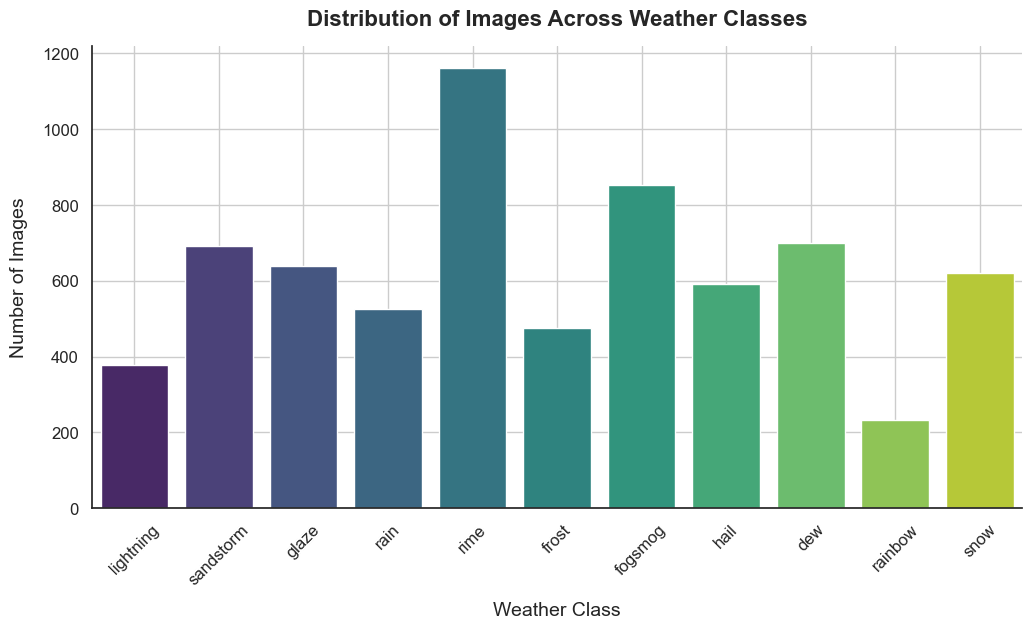

In [6]:
# Display the distribution

sns.set(style="white")

fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
bar_plot = sns.barplot(x='Class', y='Count', data=class_counts_df, palette="viridis", ax=ax)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of Images Across Weather Classes', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Weather Class', fontsize=14, labelpad=10)
plt.ylabel('Number of Images', fontsize=14, labelpad=10)

ax.grid(True)
sns.despine(ax=ax)

plt.show()

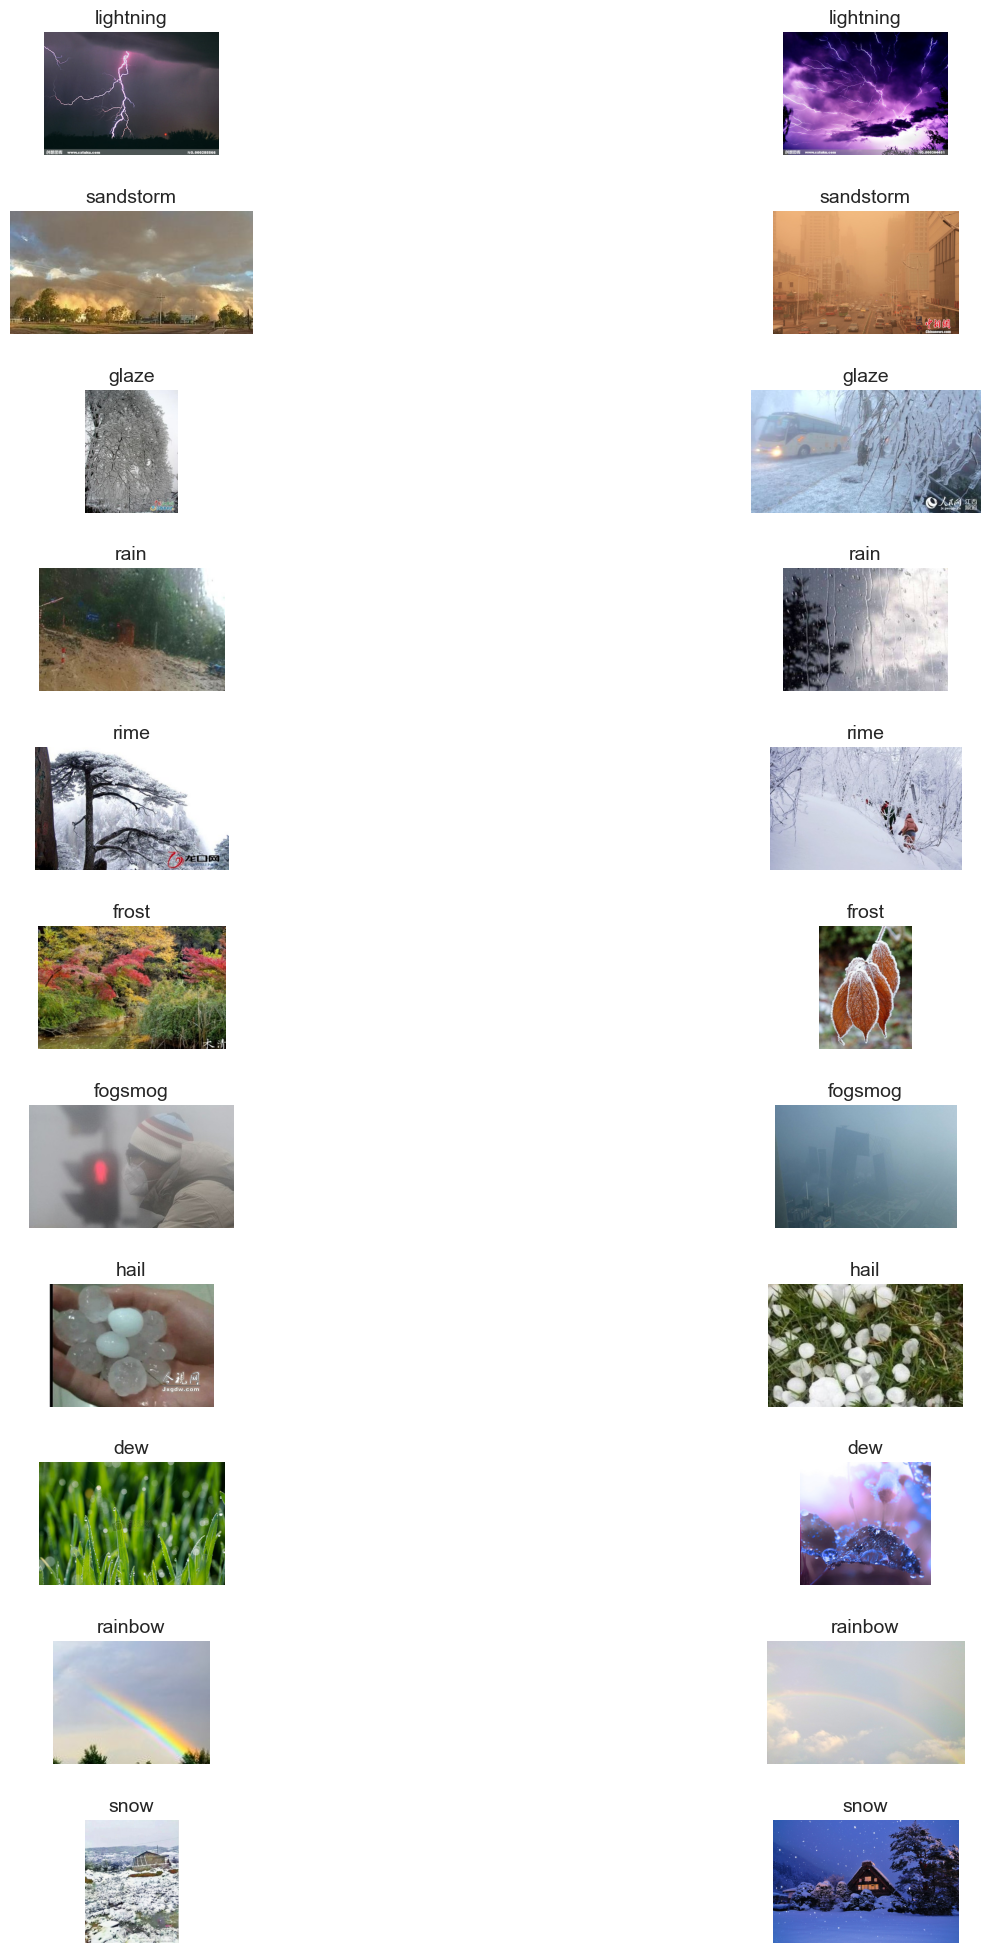

In [7]:
# Function to display sample images
def display_sample_images(dataset_path, classes, num_samples=2):
    plt.figure(figsize=(20, 20))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        sample_images = [img for img in os.listdir(class_path) if not img.startswith('.')][:num_samples]
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(np.array(img))
            plt.title(cls, fontsize=14)
            plt.axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()

# Display sample images
display_sample_images(dataset_path, classes)

dataset/lightning
dataset/sandstorm
dataset/glaze
dataset/rain
dataset/rime
dataset/frost
dataset/fogsmog
dataset/hail
dataset/dew
dataset/rainbow
dataset/snow


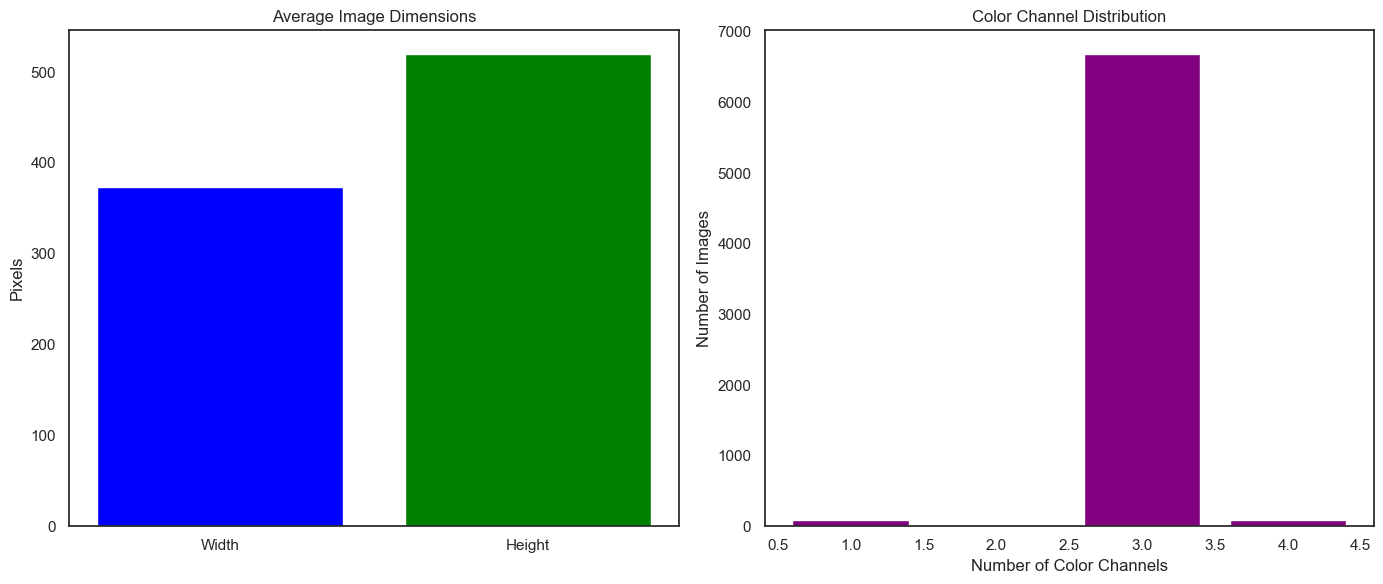


Average image dimensions:
Width: 373.8417371028855, Height: 520.0297289419995

Color channel distribution:
3 channels: 6688 images
4 channels: 86 images
1 channels: 88 images


In [8]:
# Initialize lists to store image dimensions and color channels
dim1 = []  # width
dim2 = []  # height
colors = []  # color channels

# Iterate over each subfolder and each image
for subfolder in os.listdir(dataset_path):
    subfolders_path = os.path.join(dataset_path, subfolder)
    
    if os.path.isdir(subfolders_path):  # Check if the path is a directory
        print(subfolders_path)
        
        for image_filename in os.listdir(subfolders_path):
            image_path = os.path.join(subfolders_path, image_filename)
            
            if os.path.isfile(image_path):  # Check if the path is a file
                image = imread(image_path)

                # Handle grayscale images
                if len(image.shape) < 3:
                    image = image.reshape(image.shape + (1,))
                
                d1, d2, color = image.shape
                dim1.append(d1)
                dim2.append(d2)
                colors.append(color)

# Calculate average dimensions
average_width = np.mean(dim1)
average_height = np.mean(dim2)

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot average dimensions
axes[0].bar(['Width', 'Height'], [average_width, average_height], color=['blue', 'green'])
axes[0].set_title('Average Image Dimensions')
axes[0].set_ylabel('Pixels')

# Plot color channel distribution
color_counts = Counter(colors)
axes[1].bar(color_counts.keys(), color_counts.values(), color='purple')
axes[1].set_title('Color Channel Distribution')
axes[1].set_xlabel('Number of Color Channels')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Display average dimensions
print("\nAverage image dimensions:")
print(f"Width: {average_width}, Height: {average_height}")

# Display color channel distribution
print("\nColor channel distribution:")
for channel, count in color_counts.items():
    print(f"{channel} channels: {count} images")


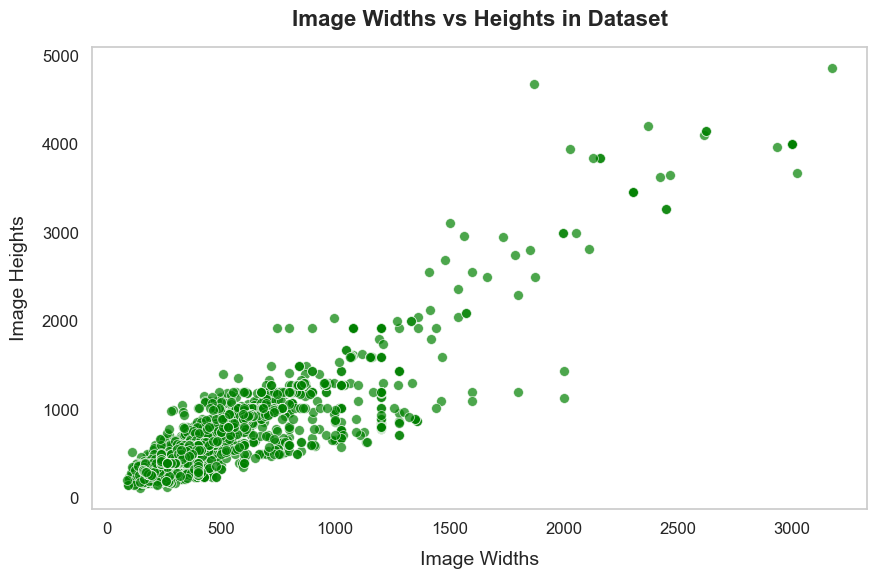

In [9]:
# Plot image dimensions

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6), facecolor='none')
scatter_plot = sns.scatterplot(x=dim1, y=dim2, alpha=0.7, edgecolor='w', s=50, color='Green')

plt.xlabel('Image Widths', fontsize=14, labelpad=10)
plt.ylabel('Image Heights', fontsize=14, labelpad=10)
plt.title('Image Widths vs Heights in Dataset', fontsize=16, fontweight='bold', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

scatter_plot.grid(False)

plt.show()

## Findings from EDA

* There are a total of 11 features:
    * dew
    * fogsmog
    * frost
    * glaze
    * hail
    * lightning
    * rain
    * rainbow
    * rime
    * sandstorm
    * snow

* We noticed that the dataset is pretty unbalanced - therefore, data augmentation and batch sampling will be implemented.

* The average Width and Height of the images:
    * Width: 373.84
    * Height: 520.03

* Color channel distribution:
    * 3 channels (RGB): 6688 images
    * 1 channel (GRAY): 88 images
    * 4 channels (RGBA): 86 images


## Preprocessing Data

The goal is to implement data augmentation and to split the data into training, validation, and test datasets. We also perform data transformations on the images to meet the model's requirements, specifically (224, 224, 3) for EfficientNet (b0), representing width, height, and color channels. Lastly, we convert the images into dataloaders for the model.

A dataloader is an iterable that simplifies batch preparation in machine learning. It efficiently loads and processes data in batches, ensuring smooth training and evaluation by handling data shuffling, parallel processing, and other essential operations.

In [10]:
# Define the transformation that converts images to RGB
def to_rgb(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image

In [11]:
# Data augmentation
data_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),  # Convert to tensor here
])

# Define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Lambda(to_rgb),  # Ensure image is RGB
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.Lambda(to_rgb),  # Ensure image is RGB
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.Lambda(to_rgb),  # Ensure image is RGB
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Path to augmented images
augmented_path = 'augmented/images'

# Count the number of samples in each class
original_dataset = WeatherDataset(root_dir=dataset_path, classes=classes)
class_counts = Counter(original_dataset.labels)
max_count = max(class_counts.values())

# Augment minority classes
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    save_to_dir = os.path.join(augmented_path, cls)
    os.makedirs(save_to_dir, exist_ok=True)
    
    num_images = len(os.listdir(class_path))
    num_to_generate = max_count - num_images
    
    for img_name in os.listdir(class_path):
        if num_to_generate <= 0:
            break
        img_path = os.path.join(class_path, img_name)
        image = Image.open(img_path).convert('RGB')
        
        for i in range(num_to_generate):
            augmented_image = data_augmentation(image)
            save_image(augmented_image, os.path.join(save_to_dir, f"{img_name.split('.')[0]}_aug_{i}.jpg"))
            num_to_generate -= 1
            if num_to_generate <= 0:
                break

In [12]:
# Define split proportions
train_ratio = 0.8
test_ratio = 0.2

# Calculate split sizes
total_size = len(original_dataset)
train_size = int(train_ratio * total_size)
test_size = int(test_ratio * total_size) + 1

# Split data into train data and test data ( ENSURES THAT TEST_DATASET DOESN'T INCLUDE AUGMENTED IMAGES )
train_dataset, test_dataset = random_split(original_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Load the augmented dataset for training
augmented_dataset = WeatherDataset(root_dir=augmented_path, classes=classes, transform=data_transforms['train'])

# Combine original train dataset and augmented dataset
combined_dataset = ConcatDataset([train_dataset, augmented_dataset])

# Determine new split sizes
new_train_size = int(0.8 * len(combined_dataset))  # 80% for training
new_val_size = len(combined_dataset) - new_train_size  # 20% for validation

# Split the combined dataset into new training and validation sets
new_train_dataset, new_val_dataset = random_split(combined_dataset, [new_train_size, new_val_size], generator=torch.Generator().manual_seed(42))

## Now we have achieved a balance dataset

In [13]:
def get_class_distribution(dataset, original_dataset, class_names):
    label_counter = Counter()
    
    for idx in dataset.indices:
        _, label_index = original_dataset[idx]
        label_name = class_names[label_index]
        label_counter[label_name] += 1
    
    return label_counter

In [15]:
# Calculate distribution
class_distribution = get_class_distribution(new_train_dataset, combined_dataset, classes)

# Convert the Counter object to a DataFrame
class_counts_df = pd.DataFrame.from_dict(class_distribution, orient='index').reset_index()
class_counts_df.columns = ['Class', 'Count']

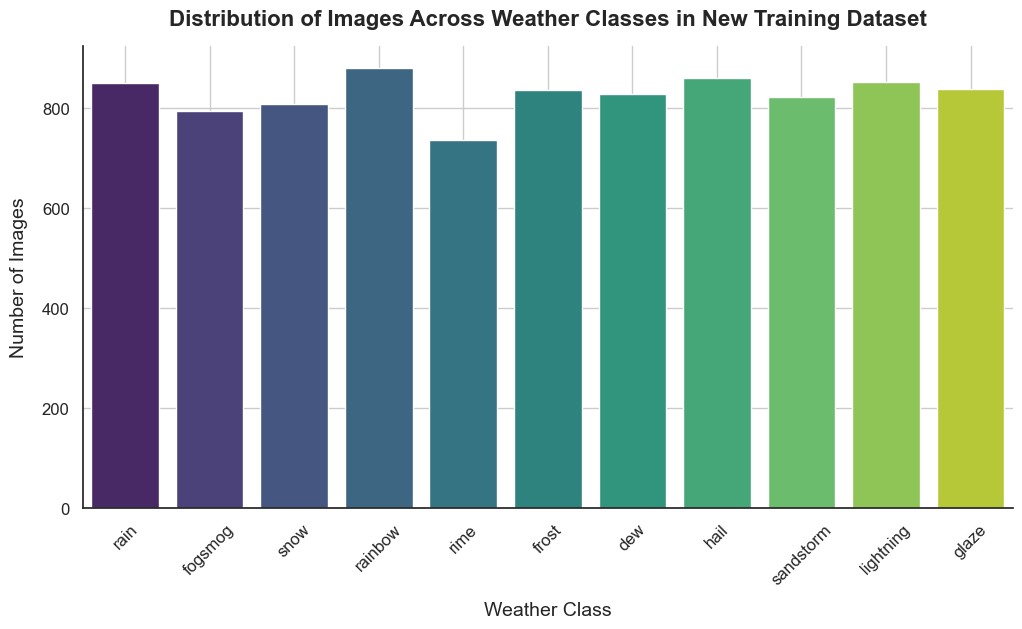

In [16]:
# Show class distribution after balancing with data augmentation
sns.set(style="white")

fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
bar_plot = sns.barplot(x='Class', y='Count', data=class_counts_df, palette="viridis", ax=ax)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of Images Across Weather Classes in New Training Dataset', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Weather Class', fontsize=14, labelpad=10)
plt.ylabel('Number of Images', fontsize=14, labelpad=10)

ax.grid(True)
sns.despine(ax=ax)

plt.show()

In [17]:
# Apply appropriate transformations to each dataset part
new_train_dataset.dataset.transform = data_transforms['train']
new_val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
batch_size = 32
train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(new_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get some dataset statistics
print(f'Training set: {len(new_train_dataset)} samples')
print(f'Validation set: {len(new_val_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

Training set: 9109 samples
Validation set: 2278 samples
Test set: 1373 samples


In [12]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint_model_EfficientNet.pth')
        self.val_loss_min = val_loss

In [13]:
# Load the pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)

# Get the number of input features to the classifier
num_ftrs = model.classifier[1].in_features

# Replace the classifier with a new one matching the number of classes
model.classifier[1] = nn.Linear(num_ftrs, len(classes))

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Define a learning rate scheduler to adjust the learning rate during training
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


c:\Users\fredr\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fredr\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, patience=7):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    # Dictionaries to store the loss and accuracy history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validating phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Important to set training mode
                dataloader = dataloaders['train']
            else:
                model.eval() # Important to set evaluate mode
                dataloader = dataloaders['val']
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameters gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only id in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Record the loss and
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Early stopping
            if phase == 'val':
                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        
        if early_stopping.early_stop:
            break

        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history
    
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Train the model
model, history = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4514 Acc: 0.8631
val Loss: 0.2697 Acc: 0.9122
Validation loss decreased (inf --> 0.269739).  Saving model ...

Epoch 1/24
----------
train Loss: 0.2424 Acc: 0.9248
val Loss: 0.1932 Acc: 0.9346
Validation loss decreased (0.269739 --> 0.193168).  Saving model ...

Epoch 2/24
----------
train Loss: 0.2086 Acc: 0.9318
val Loss: 0.1910 Acc: 0.9363
Validation loss decreased (0.193168 --> 0.190988).  Saving model ...

Epoch 3/24
----------
train Loss: 0.1605 Acc: 0.9462
val Loss: 0.1762 Acc: 0.9469
Validation loss decreased (0.190988 --> 0.176150).  Saving model ...

Epoch 4/24
----------
train Loss: 0.1371 Acc: 0.9529
val Loss: 0.2301 Acc: 0.9302
EarlyStopping counter: 1 out of 7

Epoch 5/24
----------
train Loss: 0.1306 Acc: 0.9571
val Loss: 0.2149 Acc: 0.9416
EarlyStopping counter: 2 out of 7

Epoch 6/24
----------
train Loss: 0.1114 Acc: 0.9626
val Loss: 0.1811 Acc: 0.9495
EarlyStopping counter: 3 out of 7

Epoch 7/24
----------
train Loss: 0.0559 Acc: 

In [15]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
    acc = running_corrects.double() / len(dataloader.dataset)
    return acc.item()

# Evaluate on the validation set
val_acc = evaluate_model(model, val_loader)
print(f'Validation Accuracy: {val_acc:.4f}')

# Evaluate on the test set (unseen data)
test_acc = evaluate_model(model, test_loader)
print(f'Test Accuracy (Unseen Data): {test_acc:.4f}')


Validation Accuracy: 0.9649
Test Accuracy (Unseen Data): 0.9221


In [16]:
# Save the trained model
torch.save(model.state_dict(), 'weather_classification_model_EfficientNet.pth')

In [17]:
def evaluate_model(model, dataloaders, device, classes):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())  # Collect predictions
            true_labels.extend(labels.cpu().numpy())  # Collect actual labels

    # Generate the classification report
    class_report = classification_report(true_labels, predictions, target_names=classes)
    print(class_report)

    return class_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Make sure model is on the correct device

class_report = evaluate_model(model, dataloaders, device, classes)

              precision    recall  f1-score   support

         dew       0.95      0.98      0.96       146
     fogsmog       0.91      0.96      0.94       171
       frost       0.89      0.83      0.86       100
       glaze       0.84      0.85      0.84       115
        hail       0.96      0.98      0.97       138
   lightning       0.98      1.00      0.99        81
        rain       0.92      0.90      0.91       104
     rainbow       1.00      0.98      0.99        45
        rime       0.90      0.91      0.91       211
   sandstorm       0.96      0.94      0.95       138
        snow       0.89      0.81      0.85       124

    accuracy                           0.92      1373
   macro avg       0.93      0.92      0.92      1373
weighted avg       0.92      0.92      0.92      1373



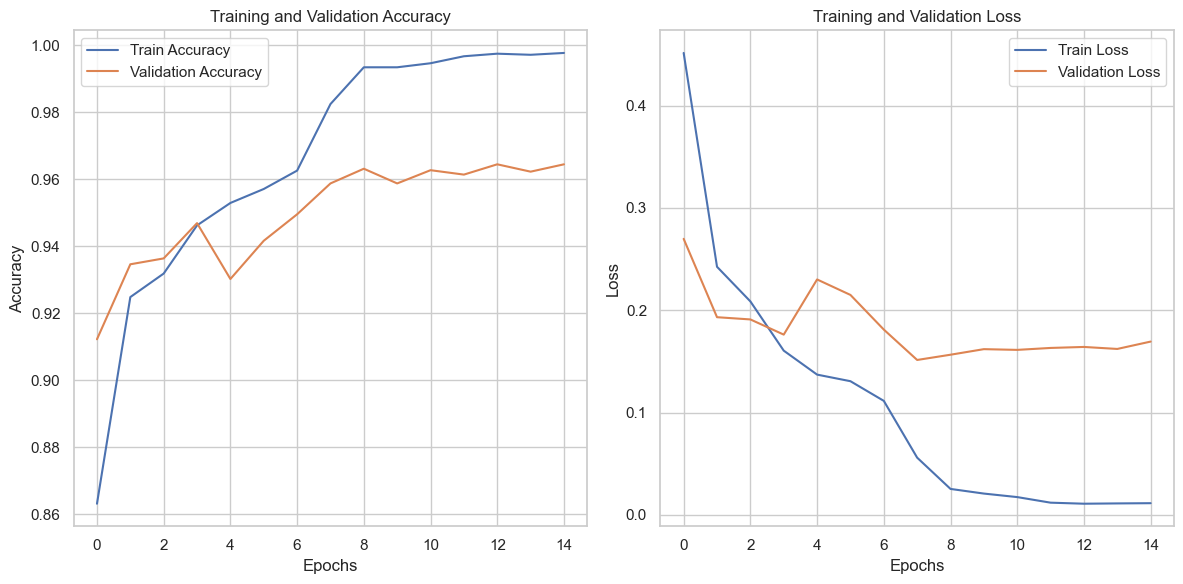

In [18]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([h.cpu().numpy() if torch.is_tensor(h) else h for h in history['train_acc']], label='Train Accuracy')
plt.plot([h.cpu().numpy() if torch.is_tensor(h) else h for h in history['val_acc']], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

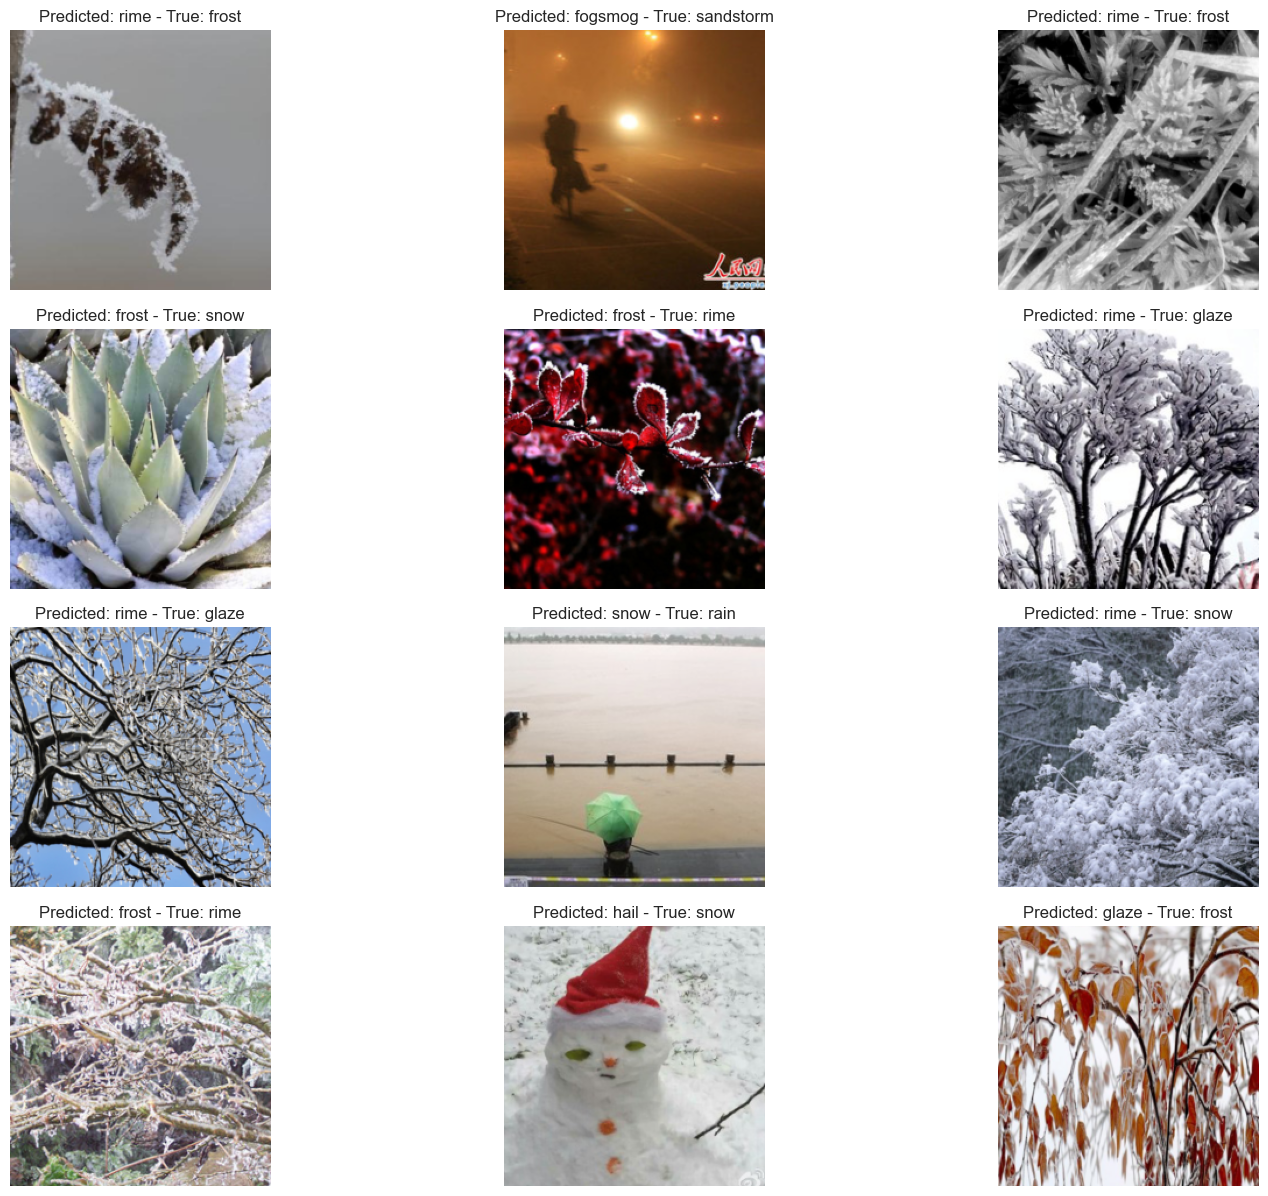

In [19]:
def visualize_misclassified_images(model, dataloader, device, classes, num_images=12):
    model.eval()  # Set the model to evaluation mode
    misclassified = []  # List to hold misclassified images and their info

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find misclassified
            mis_indices = preds != labels
            if torch.any(mis_indices):
                mis_inputs = inputs[mis_indices]
                mis_preds = preds[mis_indices]
                mis_labels = labels[mis_indices]

                for img, pred, true in zip(mis_inputs, mis_preds, mis_labels):
                    if len(misclassified) >= num_images:
                        break
                    misclassified.append((img.cpu(), classes[pred.item()], classes[true.item()]))

            if len(misclassified) >= num_images:
                break

    # Plotting
    plt.figure(figsize=(15, 3 * num_images))
    for i, (img, pred, true) in enumerate(misclassified):
        ax = plt.subplot(num_images, 3, i + 1)
        img = img.permute(1, 2, 0)  # Change CxHxW to HxWxC
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img.numpy() + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        ax.set_title(f'Predicted: {pred} - True: {true}')
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


visualize_misclassified_images(model, dataloaders['test'], device, classes)